# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Data Processing

## Read data

In [10]:
data_folder = Path("data")
last_states_folder = data_folder / "last States"

In [11]:
file_names = []
for file in data_folder.glob("*.*"):
    file_names.append(file.name)

In [13]:
ls_names = []
for file in last_states_folder.glob("*.*"):
    ls_names.append(file.name)

In [17]:
ls_data_500 = np.load(last_states_folder / ls_names[2])
Ts = ls_data_500["Ts"]
len(Ts)

100

In [18]:
file_names

['N_100_avg_std_spins_energies.npz',
 'N_250_avg_std_spins_energies.npz',
 'N_300_avg_std_spins_energies.npz',
 'N_350_avg_std_spins_energies.npz',
 'N_400_avg_std_spins_energies.npz',
 'N_450_avg_std_spins_energies.npz',
 'N_500_avg_std_spins_energies.npz']

In [21]:
net_size_dict = {}
for idx, file in enumerate(file_names):
    Ns = int(file.split("_")[1])
    net_size_dict[Ns] = idx

net_size_dict

{100: 0, 250: 1, 300: 2, 350: 3, 400: 4, 450: 5, 500: 6}

In [22]:
all_data = {}
for N_size, idx in net_size_dict.items():
    all_data[N_size] = np.load(data_folder / file_names[idx])

In [25]:
keys = ['avg_spins', 'std_spins', 'avg_energies', 'std_energies']

In [24]:
all_data

{100: NpzFile 'data\\N_100_avg_std_spins_energies.npz' with keys: avg_spins, std_spins, avg_energies, std_energies,
 250: NpzFile 'data\\N_250_avg_std_spins_energies.npz' with keys: avg_spins, std_spins, avg_energies, std_energies,
 300: NpzFile 'data\\N_300_avg_std_spins_energies.npz' with keys: avg_spins, std_spins, avg_energies, std_energies,
 350: NpzFile 'data\\N_350_avg_std_spins_energies.npz' with keys: avg_spins, std_spins, avg_energies, std_energies,
 400: NpzFile 'data\\N_400_avg_std_spins_energies.npz' with keys: avg_spins, std_spins, avg_energies, std_energies,
 450: NpzFile 'data\\N_450_avg_std_spins_energies.npz' with keys: avg_spins, std_spins, avg_energies, std_energies,
 500: NpzFile 'data\\N_500_avg_std_spins_energies.npz' with keys: avg_spins, std_spins, avg_energies, std_energies}

## Formatting

In [26]:
mags, std_mags = {}, {}
for N_size, data in all_data.items():
    mags[N_size] = data["avg_spins"]
    std_mags[N_size] = data["std_spins"]

energies, std_energies = {}, {}
for N_size, data in all_data.items():
    energies[N_size] = data["avg_energies"]
    std_energies[N_size] = data["std_energies"]

In [ ]:
# Get all magnetization data and error in a dictionary
# Keys are the net sizes, and values are the mean and error of the magnetization
mags_mean, mags_err = {}, {}
for N_size, data in all_data.items():
    mags_mean[N_size] = np.mean(data["avg_spins"], axis=1)
    mags_err[N_size] = np.std(data["avg_spins"], axis=1) / np.sqrt(len(data["avg_spins"]))

In [30]:
# Same thing for energies
energies_mean, energies_err = {}, {}
for N_size, data in all_data.items():
    energies_mean[N_size] = np.mean(data["avg_energies"], axis=1)
    energies_err[N_size] = np.std(data["avg_energies"], axis=1) / np.sqrt(len(data["avg_energies"]))

In [43]:
# Computing heat capacities with the formula C_v = dE/dT
Cv_grad, Cv_err_grad = {}, {}
for N_size, data in all_data.items():
    energies = data["avg_energies"]
    std_energies = data["std_energies"]
    Cv_grad[N_size] = np.gradient(energies.mean(axis=1), Ts) / (N_size**2)
    Cv_err_grad[N_size] = np.sqrt((np.gradient(std_energies.mean(axis=1), Ts) / (N_size**2))**2)


# Computing heat capacities using the formula C_v = (<E^2> - <E>^2)/(T^2 * N^2)
Cv_mean, Cv_err_mean = {}, {}
for N_size, data in all_data.items():
    energies = data["avg_energies"]
    std_energies = data["std_energies"]
    Cv_mean[N_size] = (np.mean(energies**2, axis=1) - np.mean(energies, axis=1)**2) / (Ts**2 * N_size**2)
    Cv_err_mean[N_size] = np.sqrt((np.std(energies**2, axis=1) / (Ts**2 * N_size**2))**2 + (np.std(energies, axis=1)**2 / (Ts**4 * N_size**4))**2)

In [45]:
heat_capacity, heat_capacity_err = {}, {}
susceptibility, susceptibility_err = {}, {}

for N_size, data in all_data.items():
    E = data["avg_energies"]  # shape (n_temps, 20)
    M = data["avg_spins"]     # shape (n_temps, 20)
    
    E_mean = np.mean(E, axis=1)
    E2_mean = np.mean(E**2, axis=1)
    M_mean = np.mean(M, axis=1)
    M2_mean = np.mean(M**2, axis=1)
    
    T = Ts 

    Cv = (E2_mean - E_mean**2) / (T**2 * N_size**2)
    chi = (M2_mean - M_mean**2) / (T * N_size**2)
    
    # Error bars via standard error propagation (assuming 20 independent samples)
    n = E.shape[1]
    E_var = np.var(E, axis=1, ddof=1)
    M_var = np.var(M, axis=1, ddof=1)
    E2_var = np.var(E**2, axis=1, ddof=1)
    M2_var = np.var(M**2, axis=1, ddof=1)
    
    # Error propagation (standard error on difference of means)
    Cv_err = np.sqrt((E2_var + 4 * (E_mean**2) * E_var) / n) / (T**2 * N_size**2)
    chi_err = np.sqrt((M2_var + 4 * (M_mean**2) * M_var) / n) / (T * N_size**2)

    heat_capacity[N_size] = Cv
    heat_capacity_err[N_size] = Cv_err
    susceptibility[N_size] = chi
    susceptibility_err[N_size] = chi_err

In [51]:
def bootstrap_statistic(samples, func, n_boot=1000):
    boot_stats = []
    n = len(samples)
    for _ in range(n_boot):
        # Resample with replacement
        resample = np.random.choice(samples, size=n, replace=True)
        boot_stats.append(func(resample))
    return np.mean(boot_stats), np.std(boot_stats)

for N_size, data in all_data.items():

    print(f"Calculating heat capacity and susceptibility for N = {N_size}")
    E = data["avg_energies"]  # shape (n_temps, 20)
    M = data["avg_spins"]
    
    T = Ts
    Cv = []
    Cv_err = []
    Chi = []
    Chi_err = []
    
    for i in range(E.shape[0]):  # for each temperature
        E_i = E[i]
        M_i = M[i]

        def cv_fn(E_sample):
            return np.var(E_sample, ddof=1) / (T[i]**2)
        
        def chi_fn(M_sample):
            return np.var(M_sample, ddof=1) / (T[i])
        
        cv_mean, cv_std = bootstrap_statistic(E_i, cv_fn)
        chi_mean, chi_std = bootstrap_statistic(M_i, chi_fn)
        
        Cv.append(cv_mean)
        Cv_err.append(cv_std)
        Chi.append(chi_mean)
        Chi_err.append(chi_std)

    heat_capacity[N_size] = np.array(Cv)
    heat_capacity_err[N_size] = np.array(Cv_err)
    susceptibility[N_size] = np.array(Chi)
    susceptibility_err[N_size] = np.array(Chi_err)


Calculating heat capacity and susceptibility for N = 100
Calculating heat capacity and susceptibility for N = 250
Calculating heat capacity and susceptibility for N = 300
Calculating heat capacity and susceptibility for N = 350
Calculating heat capacity and susceptibility for N = 400
Calculating heat capacity and susceptibility for N = 450
Calculating heat capacity and susceptibility for N = 500


In [28]:
net_size_dict

{100: 0, 250: 1, 300: 2, 350: 3, 400: 4, 450: 5, 500: 6}

## Simple Visualization (control)

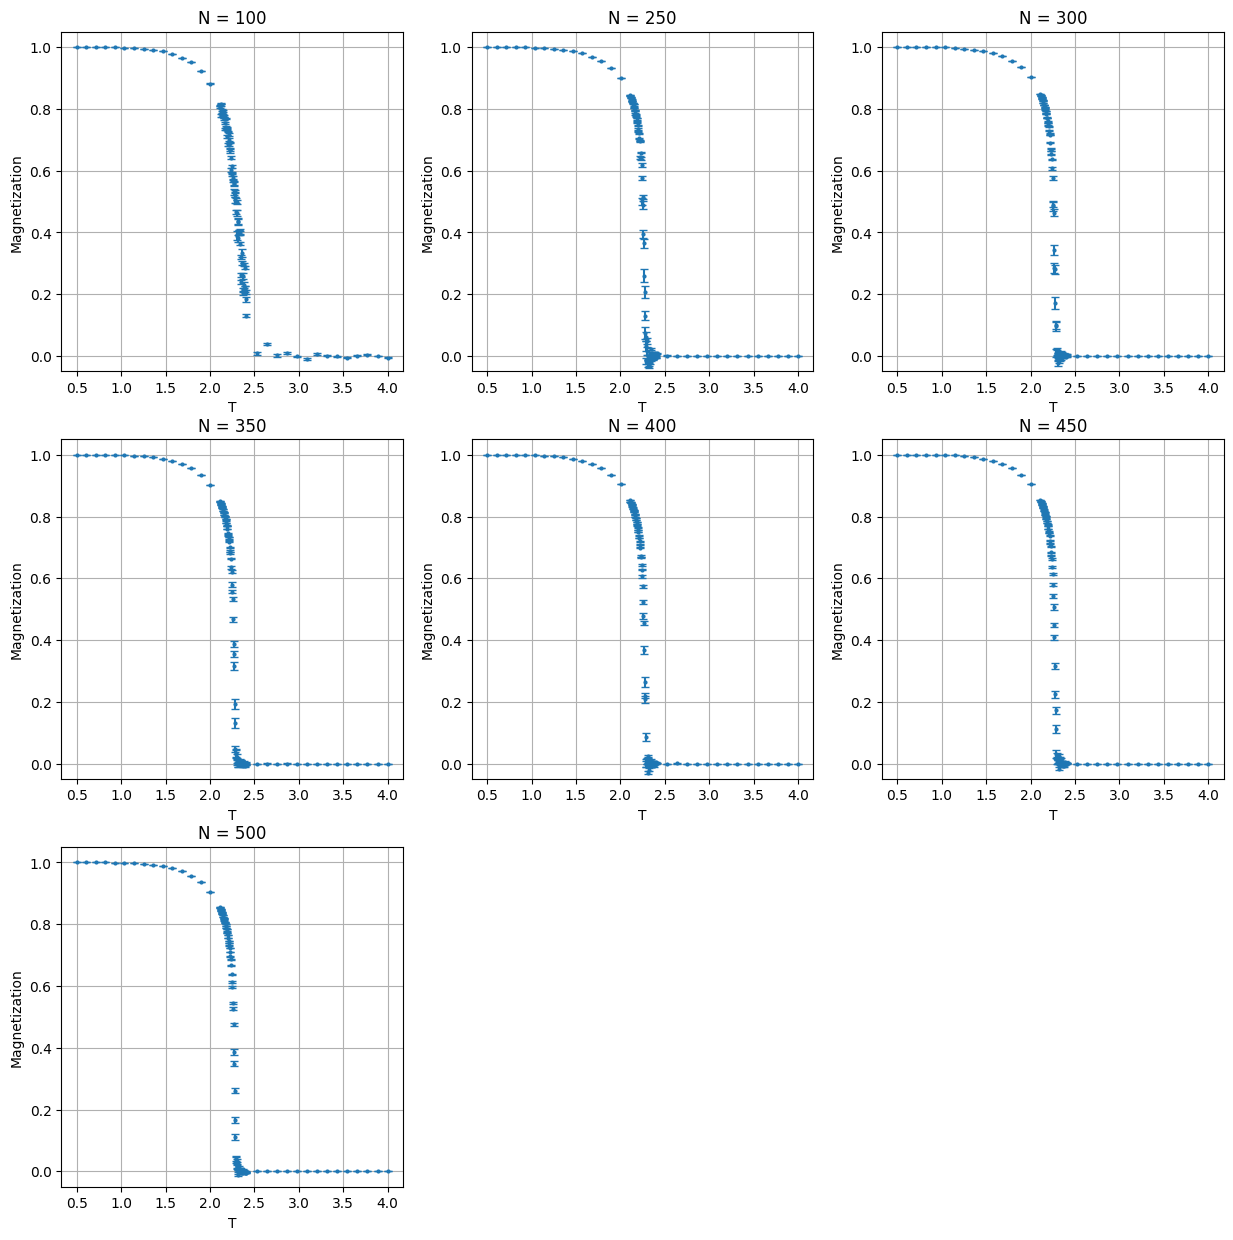

In [33]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Adjusted to 3x3 to accommodate all items
axs = axs.flatten()
for i, (N_size, idx) in enumerate(net_size_dict.items()):
    axs[i].errorbar(x=Ts, y=mags_mean[N_size], yerr=mags_err[N_size], fmt='o', markersize=2, capsize=3)
    axs[i].grid()
    axs[i].set_xlabel("T")
    axs[i].set_ylabel("Magnetization")
    axs[i].set_title(f"N = {N_size}")
    axs[i].set_ylim(-0.05, 1.05)

# Hide unused subplots if any
for j in range(len(net_size_dict), len(axs)):
    axs[j].axis('off')


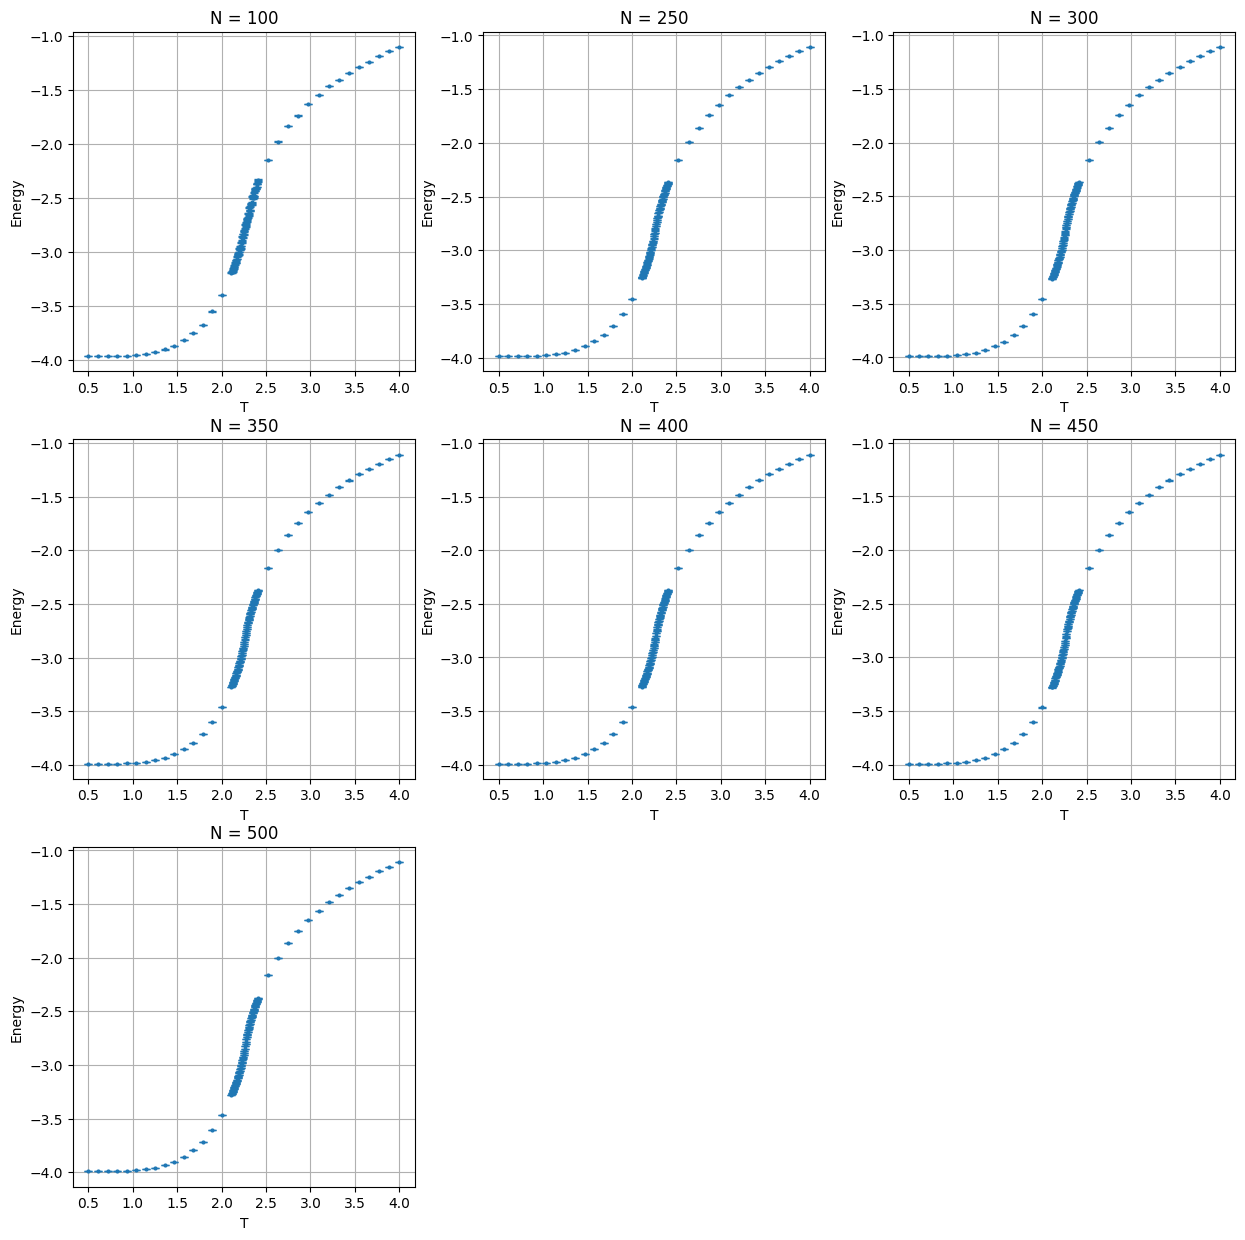

In [36]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Adjusted to 3x3 to accommodate all items
axs = axs.flatten()
for i, (N_size, idx) in enumerate(net_size_dict.items()):
    axs[i].errorbar(x=Ts, y=energies_mean[N_size]/N_size**2, yerr=energies_err[N_size]/N_size**2, fmt='o', markersize=2, capsize=3)
    axs[i].grid()
    axs[i].set_xlabel("T")
    axs[i].set_ylabel("Energy")
    axs[i].set_title(f"N = {N_size}")

# Hide unused subplots if any
for j in range(len(net_size_dict), len(axs)):
    axs[j].axis('off')

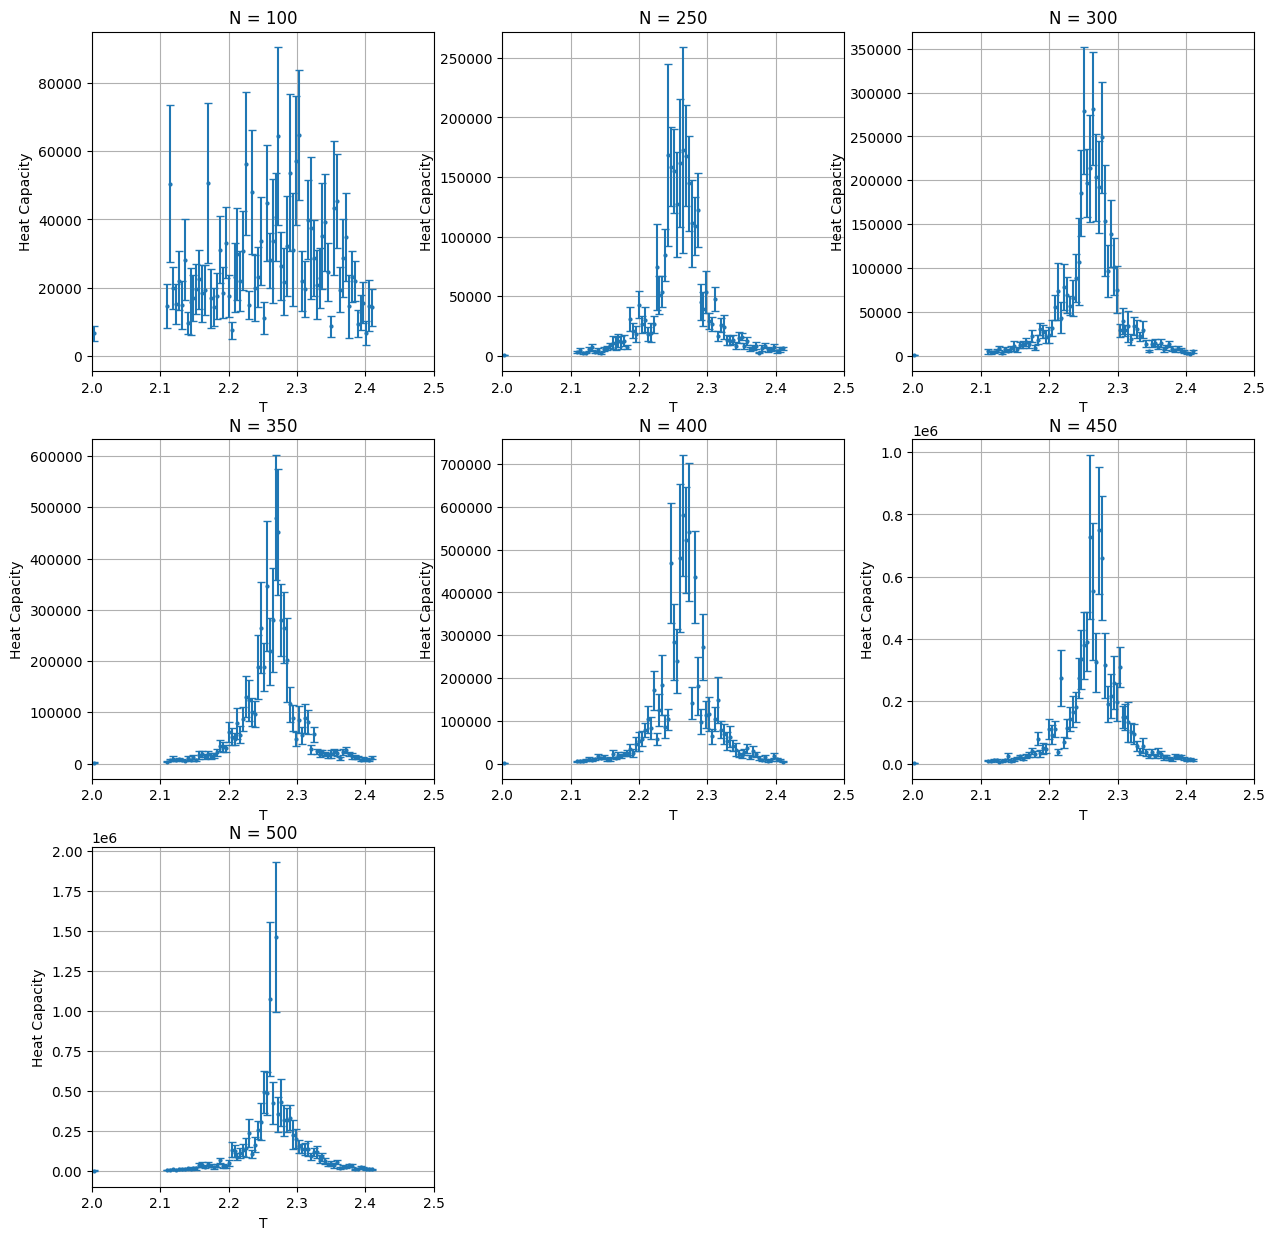

In [56]:
# Repeting the process for heat capacities (Gradient method)
fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Adjusted to 3x3 to accommodate all items
axs = axs.flatten()
for i, (N_size, idx) in enumerate(net_size_dict.items()):
    axs[i].errorbar(x=Ts, y=heat_capacity[N_size], yerr=heat_capacity_err[N_size], fmt='o', markersize=2, capsize=3)
    axs[i].grid()
    axs[i].set_xlabel("T")
    axs[i].set_ylabel("Heat Capacity")
    axs[i].set_title(f"N = {N_size}")
    axs[i].set_xlim(2.0, 2.5)


# Hide unused subplots if any
for j in range(len(net_size_dict), len(axs)):
    axs[j].axis('off')

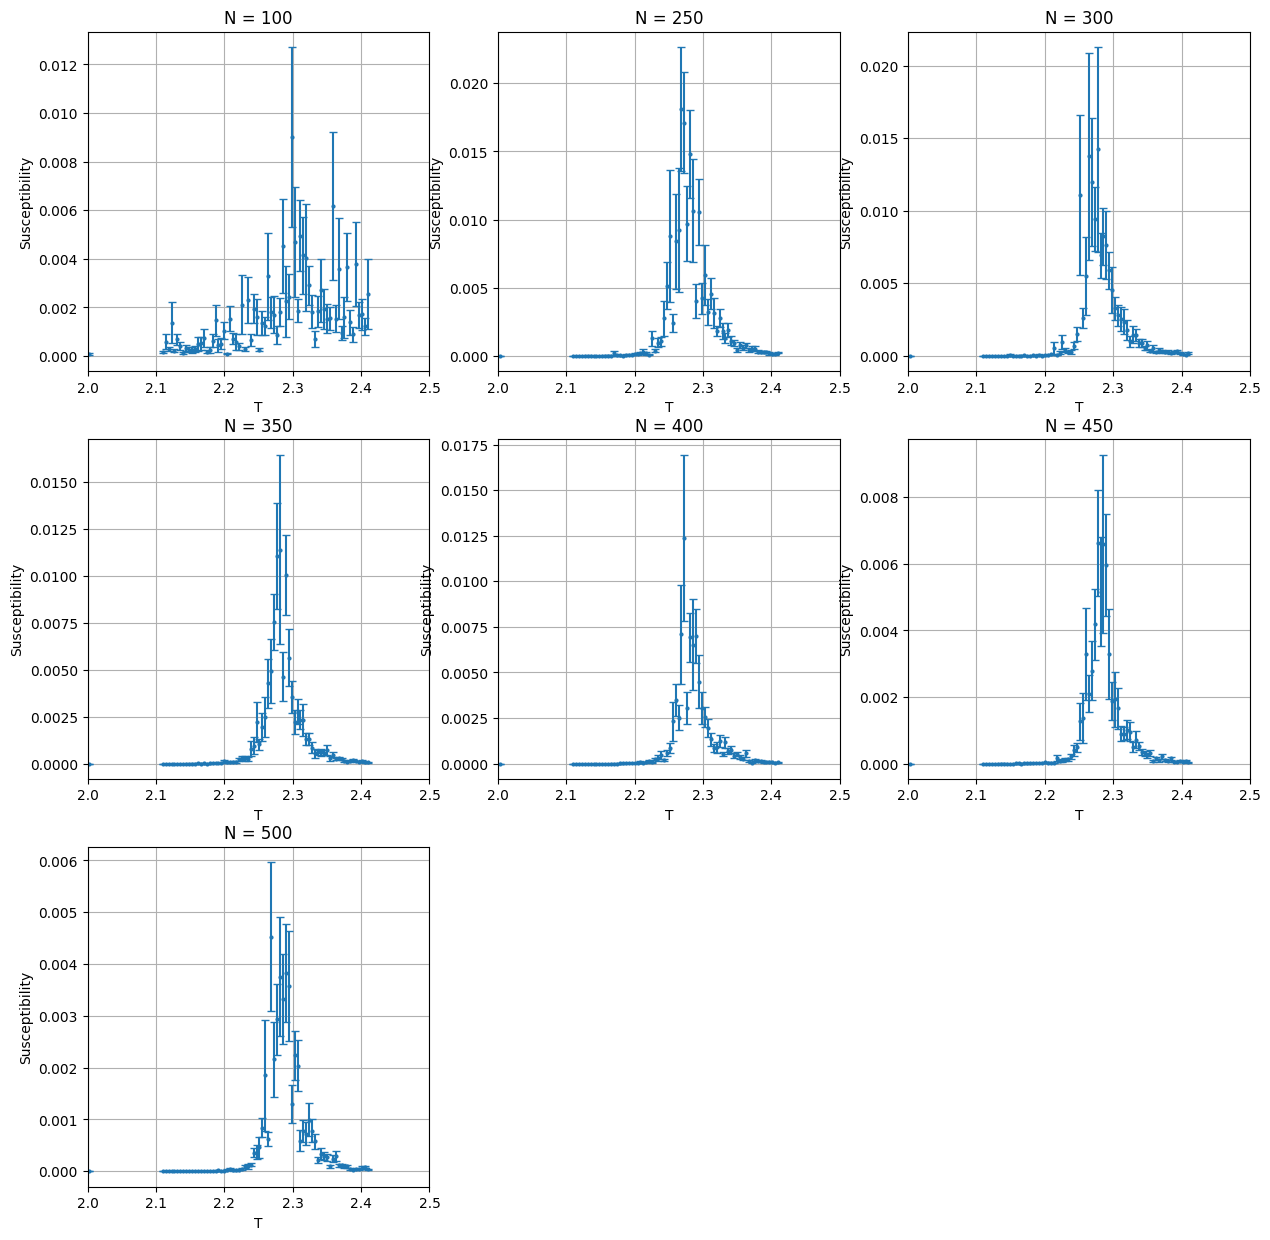

In [55]:
# Plotting susceptibility with error bars
fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Adjusted to 3x3 to accommodate all items
axs = axs.flatten()
for i, (N_size, idx) in enumerate(net_size_dict.items()):
    axs[i].errorbar(x=Ts, y=susceptibility[N_size], yerr=susceptibility_err[N_size], fmt='o', markersize=2, capsize=3)
    axs[i].grid()
    axs[i].set_xlabel("T")
    axs[i].set_ylabel("Susceptibility")
    axs[i].set_title(f"N = {N_size}")
    axs[i].set_xlim(2.0, 2.5)

# Hide unused subplots if any
for j in range(len(net_size_dict), len(axs)):
    axs[j].axis('off')